In [60]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# 2. Import feature function
import sys
import os
sys.path.append('../src')  # allow importing from src/

# 3. Import the feature generation function
from feature_engineering import generate_user_features



In [66]:
features = generate_user_features(df)
features.head(10)

C:\Users\Cesar Dushimimana\AppData\Local\Temp\ipykernel_19696\1168045382.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_time_between = grouped.apply(avg_time_between_txn).rename('avg_time_between_txn_hrs')


,userid,total_deposit_usd,total_borrow_usd,borrow_deposit_ratio,num_unique_assets,num_transactions,days_active,avg_txn_amount_usd,avg_time_between_txn_hrs
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1.987664e+09,0.000000e+00,0.000000e+00,1,1,0,1.987664e+09,0.000000
1,0x000000000051d07a4fb3bd10121a343d85818da6,2.856945e+20,0.000000e+00,0.000000e+00,1,1,0,2.856945e+20,0.000000
2,0x000000000096026fb41fc39f9875d164bd82e2dc,5.152311e+15,0.000000e+00,0.000000e+00,1,2,7,2.576155e+15,181.779167
3,0x0000000002032370b971dabd36d72f3e5a7bf1ee,2.065773e+23,6.029762e+22,2.918889e-01,6,399,132,9.517531e+20,8.012014
4,0x000000000a38444e0a6e37d3b630d7e855a7cb13,1.839067e+22,1.163143e+10,6.324638e-13,5,25,39,9.203232e+20,39.280174
5,0x000000003853fcedcd0355fec98ca3192833f00b,7.637632e+16,0.000000e+00,0.000000e+00,7,8,7,9.547039e+15,27.048690
6,0x000000003ce0cf2c037493b1dc087204bd7f713e,4.585862e+23,1.324158e+23,2.887478e-01,7,492,123,1.810733e+21,6.036733
7,0x000000007858e6f2668e1e06111cfa24403a5466,1.421607e+17,0.000000e+00,0.000000e+00,1,1,0,1.421607e+17,0.000000
8,0x00000001a0f57e850c9db68b4a9bc34677437c5c,1.766653e+06,0.000000e+00,0.000000e+00,1,1,0,1.766653e+06,0.000000
9,0x0000000506063a51c6ce59906d8c40f7d7fe92a7,7.999917e+23,5.975020e+23,7.468852e-01,1,69,30,4.052370e+22,10.819833


In [67]:
# Simulate a binary target variable for now
np.random.seed(42)
features['defaulted'] = np.random.choice([0, 1], size=len(features), p=[0.8, 0.2])


In [68]:
X = features.drop(['userid', 'defaulted'], axis=1)
y = features['defaulted']


In [69]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [70]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [71]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[547  13]
 [137   3]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.98      0.88       560
           1       0.19      0.02      0.04       140

    accuracy                           0.79       700
   macro avg       0.49      0.50      0.46       700
weighted avg       0.68      0.79      0.71       700



### Credit Scoring Model

In [73]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

def score_wallets(features_df):
    features_df = features_df.copy()
    
    # Drop userid temporarily
    user_ids = features_df['userid']
    X = features_df.drop('userid', axis=1)

    # Scale features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Unsupervised anomaly detection
    iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
    anomaly_scores = iso_forest.fit_predict(X_scaled)
    anomaly_score_values = iso_forest.decision_function(X_scaled)

    # Normalize anomaly scores to 0-1000 scale
    normalized_scores = MinMaxScaler(feature_range=(0, 1000)).fit_transform(anomaly_score_values.reshape(-1, 1)).flatten()
    
    # Flip the scores: higher score → better behavior
    final_scores = 1000 - normalized_scores

    scored_df = pd.DataFrame({
        'userid': user_ids,
        'credit_score': final_scores.round(2)
    })

    return scored_df.sort_values('credit_score', ascending=False)


#### Using Scoring Function from src\score

In [96]:
from score import compute_credit_score
scored_wallets = compute_credit_score(features)
scored_wallets.head(10)


,userid,credit_score
3209,0x05d2f53c5bd50defe43628e01197b47dcfa1764c,1000.000000
2704,0x04e492d349e82cafdc314cc0d966592b6ee9df11,979.592460
3163,0x05c18ffc1c74cb67cb26bb5222aaf3355b74bbc3,976.632188
2428,0x0464349e7012a83c965d672e9eca3896a1260624,964.078482
677,0x01222a114552e89e4c548170f8c1f4d5460d255a,963.333661
3239,0x05e09b56ec91620f9bab354c573712e446f8eb11,961.360391
1036,0x01c5c4ca74a665e40e96ed8ff221500b6366b8a6,959.790658
491,0x00c67d9d6d3d13b42a87424e145826c467cccd84,958.662134
931,0x019712e01e25a3dee2e11dc8a8de84afb0015401,958.302167
879,0x017f9dc0e2d0a123bf03a3c7ec27f898b70d8ded,956.754704


### Scoring With Model 

In [97]:
from model import score_wallets
scored_wallets = score_wallets(features)
scored_wallets.head(10)

,userid,credit_score
52,0x000f7f22bfc28d940d4b68e13213ab17cf107790,1000.00
1247,0x022b3fa410364e1e28054b704b0da3b67aa6dc90,989.88
3048,0x058b10cbe1872ad139b00326686ee8ccef274c58,981.53
1665,0x02eca8cc78b7d30c1ac5e16988ed2c8a9da658d6,978.20
130,0x0034baeeb160a5f1032b6d124d3e87cc94d74e62,970.92
1917,0x035e72ef297547349d8ce3573ebb8e10dc639816,931.03
1311,0x02491d37984764d39b99e4077649dcd349221a62,914.88
477,0x00c2e5aa91c2b6927a4e8533482c8217b450a6a1,909.30
3247,0x05e2461c8c10138aee241268f28de6003d3dbadb,906.52
92,0x00246f7813397868b1beec56e1677efa47816dae,893.48


#### Score Distribution Plot

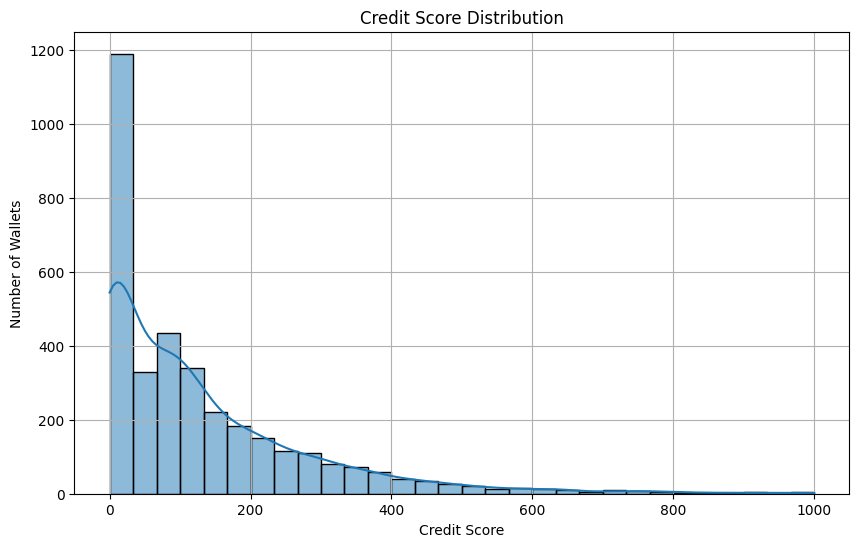

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(scored_wallets["credit_score"], bins=30, kde=True, color="#1f77b4")
plt.title("Credit Score Distribution")
plt.xlabel("Credit Score")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.show()


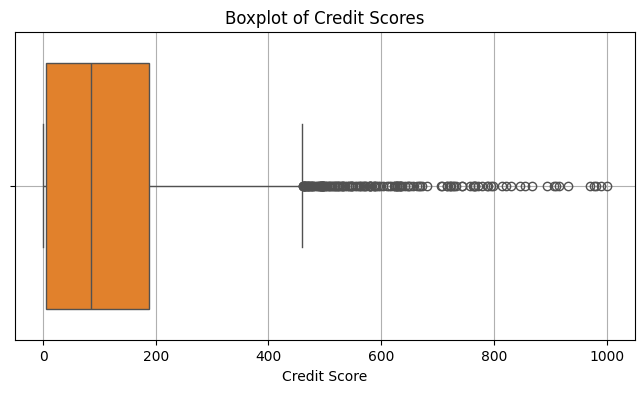

In [99]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=scored_wallets, x="credit_score", color="#ff7f0e")
plt.title("Boxplot of Credit Scores")
plt.xlabel("Credit Score")
plt.grid(True)
plt.show()


### Saving Wallet Credit Scores to CSV

In [109]:
output_path = r"C:\\Users\\Cesar Dushimimana\\Documents\\aave-credit-scoring\\data\\wallet_credit_scores.csv"
features[['userid', 'credit_score']].to_csv(output_path, index=False)

